"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [130]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import numpy as np
from scipy.stats import poisson
from tqdm import tqdm

In [4]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))

def inds_to_b(x_span):
    return 5.8889/x_span

[2.94445 0.58889]


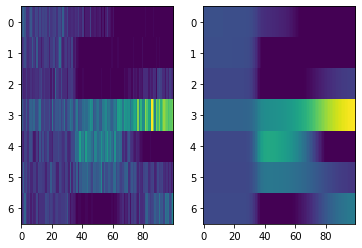

In [244]:
x = np.linspace(-10,10,100)
idx = np.arange(len(x))
states = 3
nrns = 7


#b = [20,1]
b = inds_to_b(np.array([2,10]))#[20,1]#stats.norm.rvs(0,2, size=states-1)
inflect = [-3,5]
min_val = stats.expon.rvs(10, size=nrns)#3
val_diff = stats.norm.rvs(0,30,size=(nrns,states-1))#[40,-20]

def rate_gen(min_val, diff, inflex, b):
    rate = np.ones(len(x))*min_val
    for this_b, this_diff, this_inflect in zip(b,diff,inflect):
         rate += var_sig_np(x-this_inflect,this_b)*this_diff
    return rate

rate = []
for i in range(nrns):
    this_min = min_val[i]
    this_diff = val_diff[i]
    rate.append(rate_gen(this_min, this_diff, inflect, b))
rate = np.stack(rate)
        
rate[rate<0] = 0
rate+=0.1
data_vec = poisson.rvs(rate)

fig, ax = plt.subplots(1,2)
ax[0].imshow(data_vec,aspect='auto', interpolation='nearest');
ax[1].imshow(rate,aspect='auto', interpolation='nearest');
print(b)

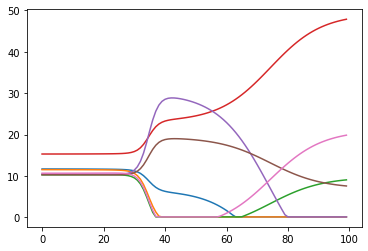

In [245]:
plt.plot(rate.T);

In [246]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-tt.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))


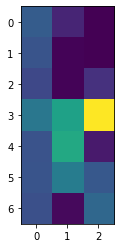

In [247]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)]).T
mean_vals += 0.01
#print(mean_vals)
plt.imshow(mean_vals);
plt.show()

In [248]:
#from itertools import accumulate as acc
#lambda_test_vals = np.array(list(acc(mean_vals, np.subtract)))
lambda_test_vals = np.diff(mean_vals, axis=-1)
lambda_test_vals

array([[ -7.66666667,  -4.27272727],
       [-10.28074866,  -0.3030303 ],
       [ -8.51604278,   5.48484848],
       [  7.12923351,  17.51515152],
       [ 14.28609626, -21.78787879],
       [  6.47593583,  -5.93939394],
       [ -8.90819964,  12.63636364]])

In [249]:
even_switches = np.linspace(0,1,states+1)[1:-1]
even_switches

array([0.33333333, 0.66666667])

In [250]:
def model_maker(sigmoid):
    with pm.Model() as model:

        s0 = pm.Exponential('state0', 
                            1/(np.mean(mean_vals)),
                            shape = nrns,
                            testval = mean_vals[:,0])

        lambda_diff = pm.Normal('lambda_diff', 
                                mu = 0, sigma = 10, 
                                shape = (nrns,states-1), 
                                testval = lambda_test_vals)


        a = pm.HalfCauchy('a_tau', 10, shape = states - 1)
        b = pm.HalfCauchy('b_tau', 10, shape = states - 1)

        tau_latent = pm.Beta('tau_latent', a, b, 
                             testval = even_switches,
                             shape = (states-1)).sort(axis=-1)    
        tau = pm.Deterministic('tau', 
                idx.min() + (idx.max() - idx.min()) * tau_latent)

        weight1 = sigmoid(idx-tau[0])
        weight2 = sigmoid(idx-tau[1])
        weight_stack = tt.stack([weight1,weight2])
        weight_stack_temp = tt.tile(weight_stack[None,:,:],(nrns,1,1))

        s0_temp = tt.tile(s0[:,None,None], (1,states-1, len(idx)))
        lambda_diff_temp = tt.tile(lambda_diff[:,:,None], (1,1, len(idx)))
        lambda_ =  pm.Deterministic('lambda_',
                        tt.sum(s0_temp + (weight_stack_temp*lambda_diff_temp),axis=1))
        lambda_bounded = pm.Deterministic("lambda_bounded", tt.switch(lambda_>=0.01, lambda_, 0.01))

        # Add observations
        observation = pm.Poisson("obs", lambda_bounded, observed=data_vec)
    return model

In [251]:
def sigmoid_gen(x_span):
    def func(x):
        return 1/(1+tt.exp(-inds_to_b(x_span)*x))
    return func

In [252]:
x_span = np.linspace(1,60,10)
sigmoid_list = [sigmoid_gen(this_x) for this_x in x_span]

In [253]:
# sig_func = sigmoid_list[0]
# plt.plot(sig_func(x).eval())

In [254]:
model_list = [model_maker(this_sig) for this_sig in tqdm(sigmoid_list)]


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


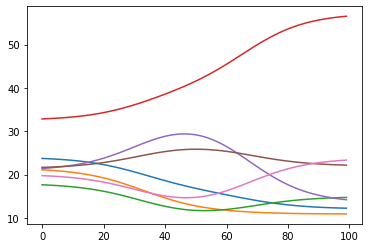

In [255]:
plt.plot(model_list[-1].lambda_bounded.tag.test_value.T);

In [256]:
# plt.imshow(lambda_bounded.tag.test_value,aspect='auto', interpolation='nearest');

In [257]:
# pm.model_to_graphviz(model)

In [258]:
fit = 40000
samples = 10000
trace_list = []
approx_list = []
for this_model in tqdm(model_list):
    with this_model:
            inference = pm.ADVI('full-rank')
            approx = pm.fit(n=fit, method=inference)
            trace = approx.sample(draws=samples)
            approx_list.append(approx)
            trace_list.append(trace)


  0%|          | 0/10 [00:00<?, ?it/s]

Finished [100%]: Average Loss = 1,779.2

 10%|█         | 1/10 [00:12<01:52, 12.55s/it]

Finished [100%]: Average Loss = 1,685.7

 20%|██        | 2/10 [00:24<01:38, 12.32s/it]

Finished [100%]: Average Loss = 1,627.2

 30%|███       | 3/10 [00:38<01:30, 12.99s/it]

Finished [100%]: Average Loss = 1,605.2

 40%|████      | 4/10 [00:51<01:16, 12.76s/it]

Finished [100%]: Average Loss = 1,603.1

 50%|█████     | 5/10 [01:03<01:02, 12.54s/it]

Finished [100%]: Average Loss = 1,613.4

 60%|██████    | 6/10 [01:16<00:51, 12.90s/it]

Finished [100%]: Average Loss = 1,631.3

 70%|███████   | 7/10 [01:29<00:38, 12.69s/it]

Finished [100%]: Average Loss = 1,657.5

 80%|████████  | 8/10 [01:41<00:25, 12.51s/it]

Finished [100%]: Average Loss = 1,690.3

 90%|█████████ | 9/10 [01:53<00:12, 12.34s/it]

Finished [100%]: Average Loss = 1,728.2

100%|██████████| 10/10 [02:05<00:00, 12.50s/it]


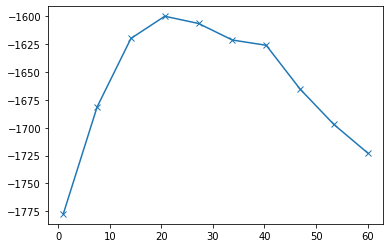

In [259]:
elbo_list = [-approx.hist[-1] for approx in approx_list]
plt.plot(x_span, elbo_list,'-x')

In [280]:
best_model_ind = 0#np.argmax(elbo_list)
model = model_list[best_model_ind]
approx = approx_list[best_model_ind]
trace = trace_list[best_model_ind]

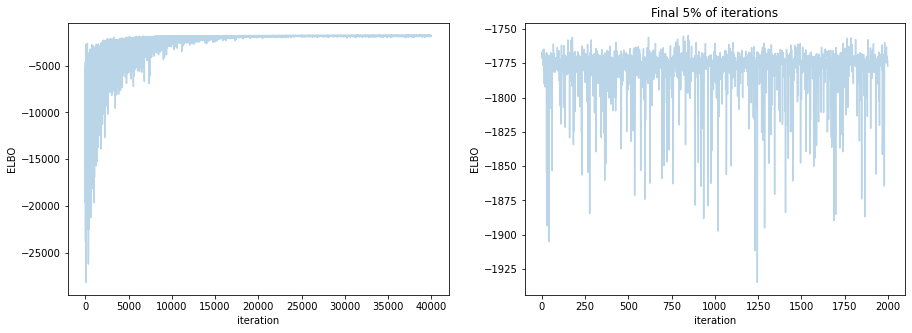

In [281]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [282]:
# with model:
#     pm.traceplot(trace, varnames = ['tau', 'state0', 'lambda_diff'])

In [283]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
tau = trace['tau']
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


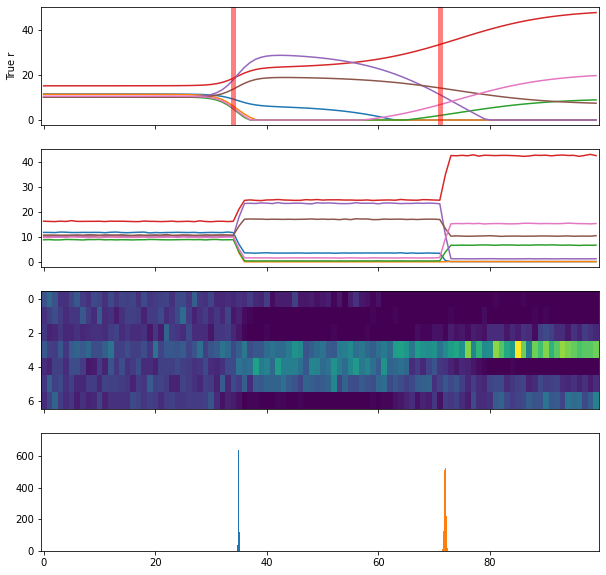

In [284]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
ax[0].plot(rate.T)
ax[0].set_ylabel('True r')
ax[1].plot(np.mean(ppc['obs'],axis=0).T)
ax[2].imshow(data_vec, interpolation='nearest', aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[3].hist(this_tau,bins=50)
    ax[0].axvline(mode_tau[tau_num],color='red',alpha=0.5,linewidth=5)

In [ ]:
:vs